# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from matplotlib_venn import venn3
from pandas.errors import SettingWithCopyWarning
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
from utils import *

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

%matplotlib inline

# Data import

## Antibody pairs

In [2]:
antibody_pairs = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs.csv")

## Cluster comparison

In [3]:
cluster_comparison = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs_cluster_comparison.csv")
print("Number of antibody pairs with cluster information:", len(cluster_comparison))

Number of antibody pairs with cluster information: 213


## IGX-Cluster

In [4]:
cluster_full = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/IGX_Cluster_clustering.tsv", sep="\t",
    low_memory=False)

In [5]:
# separate germline and study sequences for all dataframes
germline, cluster = separate_germline_seq(cluster_full) 

# filter for heavy and light chains
cluster_heavy = cluster[cluster["Chain"] == "Heavy"]
cluster_light = cluster[cluster["Chain"].isin(["Lambda", "Kappa"])]

Germline sequences: 10197
Unique antibodies: 10490


In [6]:
igx = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs_clustered_IGX.csv")
print("Number of antibody pairs clustered by IGX-Cluster:", len(igx))

Number of antibody pairs clustered by IGX-Cluster: 54


## SAAB+

In [7]:
saabplus = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs_clustered_SAAB+.csv")
print("Number of antibody pairs clustered by SAAB+:", len(saabplus))

Number of antibody pairs clustered by SAAB+: 54


## SPACE2

In [8]:
space2 = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/antibody_pairs/Antibody_pairs_clustered_SPACE2.csv")
print("Number of antibody pairs clustered by SPACE2:", len(space2))

Number of antibody pairs clustered by SPACE2: 54


In [9]:
space2_full = pd.read_csv(os.path.dirname(os.getcwd()) + "/data/clustering/SPACE2_clustering.csv")
space2_full.rename(columns={"ID":"Clone_ID"}, inplace=True)
# create integer mapping for unique strings
integer_mapping = {string: i for i, string in enumerate(space2_full["cluster_by_rmsd"].unique())}
# replace strings with integers 
space2_full["cluster_by_rmsd"] = space2_full["cluster_by_rmsd"].map(integer_mapping)
# extract ID from path string
space2_full["Clone_ID"] = space2_full["Clone_ID"].apply(rename_ID)

# Cluster comparison

In [10]:
pal = sns.color_palette(palette="Set2")
pal

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [11]:
cluster_summary = cluster_comparison[["Epitope_ID_A", "Epitope_ID_B", "Clone_ID_A", "Clone_ID_B", "IGX_clustered", 
    "SPACE2_clustered", "SPACE2_clustered_length", "SAABplus_clustered"]]
cluster_summary["Clustered"] = cluster_summary[["IGX_clustered", "SPACE2_clustered", "SAABplus_clustered"]].sum(axis=1)
cluster_summary["Clustered"].value_counts().sort_index()

Clustered
0    184
1     13
2      7
3      9
Name: count, dtype: int64

In [12]:
antibody_pairs_cluster_summary = antibody_pairs.merge(cluster_summary, on=["Epitope_ID_A", "Epitope_ID_B"])
antibody_pairs_cluster_summary = antibody_pairs_cluster_summary.apply(add_gene_match, args=[cluster_heavy], axis=1)

In [13]:
df_igx = antibody_pairs_cluster_summary[antibody_pairs_cluster_summary["IGX_clustered"] == True]
df_igx["Cluster_method"] = "Clustered by IGX-Cluster"
df_saabplus = antibody_pairs_cluster_summary[antibody_pairs_cluster_summary["SAABplus_clustered"] == True]
df_saabplus["Cluster_method"] = "Clustered by SAAB+"
df_space2 = antibody_pairs_cluster_summary[antibody_pairs_cluster_summary["SPACE2_clustered"] == True]
df_space2["Cluster_method"] = "Clustered by SPACE2"
df_all = antibody_pairs_cluster_summary
df_all["Cluster_method"] = "All"

cluster_df = pd.concat([df_igx, df_saabplus, df_space2, df_all], axis=0)

In [14]:
cluster_df["Cluster_method"].value_counts()

Cluster_method
All                         213
Clustered by IGX-Cluster     24
Clustered by SAAB+           16
Clustered by SPACE2          14
Name: count, dtype: int64

In [15]:
print("Number of antibody pairs clustered by IGX-Cluster:", 
      len(cluster_df[cluster_df["Cluster_method"] == "Clustered by IGX-Cluster"]))
print("Number of antibody pairs clustered by SAAB+:", len(cluster_df[cluster_df["Cluster_method"] == "Clustered by SAAB+"]))
print("Number of antibody pairs clustered by SPACE2:", len(cluster_df[cluster_df["Cluster_method"] == "Clustered by SPACE2"]))

Number of antibody pairs clustered by IGX-Cluster: 24
Number of antibody pairs clustered by SAAB+: 16
Number of antibody pairs clustered by SPACE2: 14


In [16]:
print("Number of low sequence similarity antibody pairs clustered by IGX-Cluster:", 
    len(cluster_df[(cluster_df["Cluster_method"] == "Clustered by IGX-Cluster") & (cluster_df["Distance_normalized"] < 0.8)]))
print("Number of low sequence similarity antibody pairs clustered by SAAB+:", 
    len(cluster_df[(cluster_df["Cluster_method"] == "Clustered by SAAB+") & (cluster_df["Distance_normalized"] < 0.8)]))
print("Number of low sequence similarity antibody pairs clustered by SPACE2:", 
    len(cluster_df[(cluster_df["Cluster_method"] == "Clustered by SPACE2") & (cluster_df["Distance_normalized"] < 0.8)]))

Number of low sequence similarity antibody pairs clustered by IGX-Cluster: 8
Number of low sequence similarity antibody pairs clustered by SAAB+: 5
Number of low sequence similarity antibody pairs clustered by SPACE2: 5


In [17]:
only_igx_clustered = cluster_summary[(cluster_summary["Clustered"] == 1) & (cluster_summary["IGX_clustered"] == True)] \
    [["Epitope_ID_A", "Epitope_ID_B"]]
only_space2_clustered = cluster_summary[(cluster_summary["Clustered"] == 1) & (cluster_summary["SPACE2_clustered"] == True)] \
    [["Epitope_ID_A", "Epitope_ID_B"]]
only_saabplus_clustered = cluster_summary[(cluster_summary["Clustered"] == 1) & \
    (cluster_summary["SAABplus_clustered"] == True)][["Epitope_ID_A", "Epitope_ID_B"]]
print("Number of antibody pairs only clustered by IGX-Cluster:", len(only_igx_clustered))
print("Number of antibody pairs only clustered by SPACE2:", len(only_space2_clustered))
print("Number of antibody pairs only clustered by SAAB+:", len(only_saabplus_clustered))

Number of antibody pairs only clustered by IGX-Cluster: 9
Number of antibody pairs only clustered by SPACE2: 3
Number of antibody pairs only clustered by SAAB+: 1


In [18]:
set_igx = {(row["Epitope_ID_A"], row["Epitope_ID_B"]) for index, row in 
    cluster_summary[cluster_summary["IGX_clustered"] == True].iterrows()}
set_saabplus = {(row["Epitope_ID_A"], row["Epitope_ID_B"]) for index, row in 
    cluster_summary[cluster_summary["SAABplus_clustered"] == True].iterrows()}
set_space2 = {(row["Epitope_ID_A"], row["Epitope_ID_B"]) for index, row in 
    cluster_summary[cluster_summary["SPACE2_clustered"] == True].iterrows()}

## Visualization

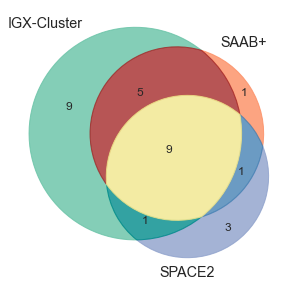

In [19]:
sns.set(style=("ticks"), font_scale=1, palette="Set2")
fig, ax = plt.subplots(1, 1, figsize=(7,5))

v = venn3(subsets=(set_igx, set_saabplus, set_space2), set_labels=("IGX-Cluster", "SAAB+", "SPACE2"), alpha=0.8);
v.get_patch_by_id("100").set_color(pal[0])
v.get_patch_by_id("010").set_color(pal[1])
v.get_patch_by_id("001").set_color(pal[2])
v.get_patch_by_id("101").set_color("darkcyan")
v.get_patch_by_id("110").set_color("brown")
v.get_patch_by_id("011").set_color("steelblue")
v.get_patch_by_id("111").set_color("khaki")

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Venn_clustering_approaches.png", dpi=300, transparent=True,
    bbox_inches="tight")

In [20]:
stat1, p1 = mannwhitneyu(df_all["Distance_normalized"], df_igx["Distance_normalized"])
stat2, p2 = mannwhitneyu(df_all["Distance_normalized"], df_saabplus["Distance_normalized"])
stat3, p3 = mannwhitneyu(df_all["Distance_normalized"], df_space2["Distance_normalized"])

rejected, p_adj_distance = fdrcorrection([p1, p2, p3])
    
stat1, p1 = mannwhitneyu(df_all["Jaccard_score"], df_igx["Jaccard_score"])
stat2, p2 = mannwhitneyu(df_all["Jaccard_score"], df_saabplus["Jaccard_score"])
stat3, p3 = mannwhitneyu(df_all["Jaccard_score"], df_space2["Jaccard_score"])

rejected, p_adj_overlap = fdrcorrection([p1, p2, p3])

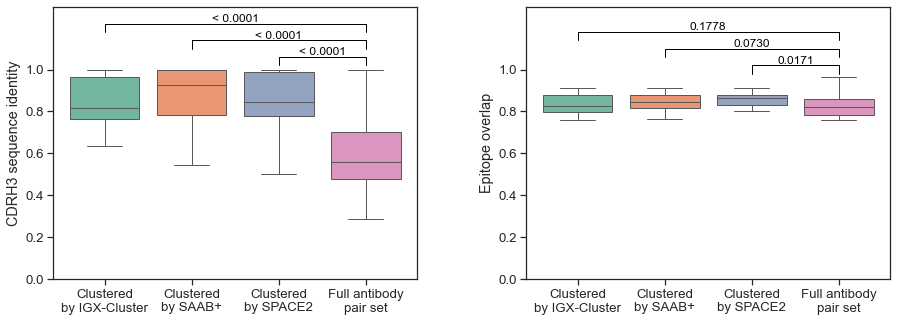

In [21]:
sns.set(style=("ticks"), font_scale=1.2, palette="Set2")
fig, ax = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(wspace=0.3)

labels = ["Clustered\nby IGX-Cluster", "Clustered\nby SAAB+", "Clustered\nby SPACE2", "Full antibody\npair set"]

sns.boxplot(data=cluster_df, y="Distance_normalized", x="Cluster_method", palette="Set2", ax=ax[0])
ax[0].set(xlabel=None, ylabel="CDRH3 sequence identity", ylim=(0,1.3))
ax[0].set_xticks(ticks=[0,1,2,3], labels=labels)
ax[0].set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

h = 0.04

# add p-value annotations
y = 1.18
ax[0].plot([0, 0, 3, 3], [y, y+h, y+h, y], color="k", linewidth=1)
ax[0].text(1.5, y+h, print_p_val(p_adj_distance[0]), ha="center", va="bottom", color="black", size=12, weight=1)
y = 1.1
ax[0].plot([1, 1, 3, 3], [y, y+h, y+h, y], color="k", linewidth=1)
ax[0].text(2, y+h, print_p_val(p_adj_distance[1]), ha="center", va="bottom", color="black", size=12, weight=1)
y = 1.02
ax[0].plot([2, 2, 3, 3], [y, y+h, y+h, y], color="k", linewidth=1)
ax[0].text(2.5, y+h, print_p_val(p_adj_distance[2]), ha="center", va="bottom", color="black", size=12, weight=1)

sns.boxplot(data=cluster_df, y="Jaccard_score", x="Cluster_method", palette="Set2", ax=ax[1])
ax[1].set(xlabel=None, ylabel="Epitope overlap", ylim=(0,1.3))
ax[1].set_xticks(ticks=[0,1,2,3], labels=labels)
ax[1].set_yticks(ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

# add p-value annotations
y = 1.14
ax[1].plot([0, 0, 3, 3], [y, y+h, y+h, y], color="k", linewidth=1)
ax[1].text(1.5, y+h, print_p_val(p_adj_overlap[0]), ha="center", va="bottom", color="black", size=12, weight=1)
y = 1.06
ax[1].plot([1, 1, 3, 3], [y, y+h, y+h, y], color="k", linewidth=1)
ax[1].text(2, y+h, print_p_val(p_adj_overlap[1]), ha="center", va="bottom", color="black", size=12, weight=1)
y = 0.98
ax[1].plot([2, 2, 3, 3], [y, y+h, y+h, y], color="k", linewidth=1)
ax[1].text(2.5, y+h, print_p_val(p_adj_overlap[2]), ha="center", va="bottom", color="black", size=12, weight=1)

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Clustering_approaches_comparison.png", dpi=300, transparent=True,
    bbox_inches="tight")

In [22]:
df_plotting = antibody_pairs_cluster_summary.sort_values("Species", ascending=False)
df_plotting["Species"] = np.where(df_plotting["Species"] == "Severe acute respiratory syndrome coronavirus 2", 
    "SARS-CoV-2", df_plotting["Species"])
df_plotting["Species"] = np.where(df_plotting["Species"] == "Human immunodeficiency virus 1", "HIV", 
    df_plotting["Species"])
df_plotting["Species"] = np.where(df_plotting["Species"] == "Saccharomyces cerevisiae", "S. cerevisiae", 
    df_plotting["Species"])
df_plotting["Species"] = np.where(df_plotting["Species"] == "Plamodium falciparum", "P. falciparum", 
    df_plotting["Species"])

In [23]:
df_plotting["Clustered_by"] = "whitesmoke"
df_plotting["Clustered_by"] = np.where(df_plotting["IGX_clustered"] == True, "mediumaquamarine", df_plotting["Clustered_by"])
df_plotting["Clustered_by"] = np.where(df_plotting["SAABplus_clustered"] == True, "salmon", df_plotting["Clustered_by"])
df_plotting["Clustered_by"] = np.where(df_plotting["SPACE2_clustered"] == True, "lightslategray", df_plotting["Clustered_by"])
df_plotting["Clustered_by"] = np.where((df_plotting["IGX_clustered"] == True) & (df_plotting["SAABplus_clustered"] == True), 
    "brown", df_plotting["Clustered_by"])
df_plotting["Clustered_by"] = np.where((df_plotting["IGX_clustered"] == True) & (df_plotting["SPACE2_clustered"] == True), 
    "darkcyan", df_plotting["Clustered_by"])
df_plotting["Clustered_by"] = np.where((df_plotting["SAABplus_clustered"] == True) & (df_plotting["SPACE2_clustered"] == True), 
    "steelblue", df_plotting["Clustered_by"])
df_plotting["Clustered_by"] = np.where((df_plotting["IGX_clustered"] == True) & (df_plotting["SAABplus_clustered"] == True) \
    & (df_plotting["SPACE2_clustered"] == True), "khaki", df_plotting["Clustered_by"])

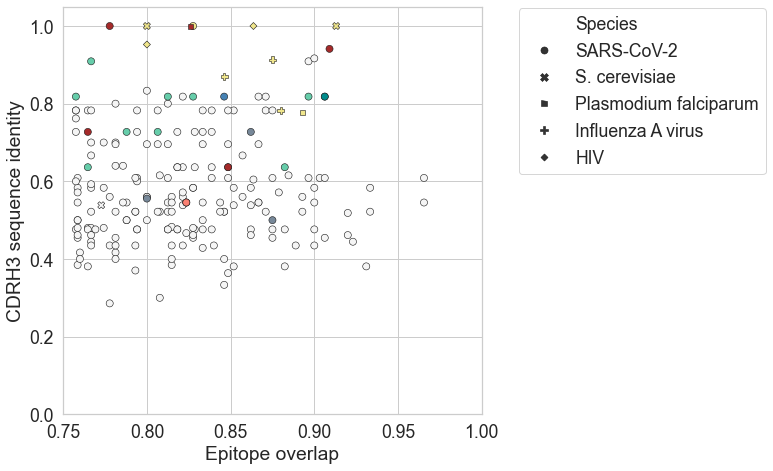

In [24]:
sns.set(style=("whitegrid"), font_scale=1.6)
fig, ax = plt.subplots(1, 1, figsize=(7.5,7.5))

color_dict = {color: color for color in df_plotting["Clustered_by"].unique()}

data = df_plotting[df_plotting["Clustered_by"] == "whitesmoke"]
sns.scatterplot(data=data, x="Jaccard_score", y="Distance_normalized", hue="Clustered_by", style="Species", s=50, 
    palette=color_dict, edgecolor="k", ax=ax)
data = df_plotting[df_plotting["Clustered_by"] != "whitesmoke"]
sns.scatterplot(data=data, x="Jaccard_score", y="Distance_normalized", hue="Clustered_by", style="Species", s=50, 
    palette=color_dict, edgecolor="k", ax=ax)
ax.set(title=None, xlabel="Epitope overlap", ylabel="CDRH3 sequence identity", xlim=(0.75,1), ylim=(0,1.05))

handles, labels = ax.get_legend_handles_labels()
filtered_handles = handles[13:]  
filtered_labels = labels[13:]
ax.legend(handles=filtered_handles, labels=filtered_labels, bbox_to_anchor=(1.7,1.018))

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Antibody_pairs_clustered.png", dpi=300, transparent=True,
    bbox_inches="tight")

In [25]:
antibody_pairs_cluster_summary["Gene_match"] = np.where((antibody_pairs_cluster_summary["V_gene_match"] == True), "V", "None")
antibody_pairs_cluster_summary["Gene_match"] = np.where((antibody_pairs_cluster_summary["V_gene_match"] == True) & \
    (antibody_pairs_cluster_summary["J_gene_match"] == True), "V/J", antibody_pairs_cluster_summary["Gene_match"])

## Partioning

In [26]:
antibody_pairs_cluster_summary["Gene_match"].value_counts()

Gene_match
V       86
None    64
V/J     63
Name: count, dtype: int64

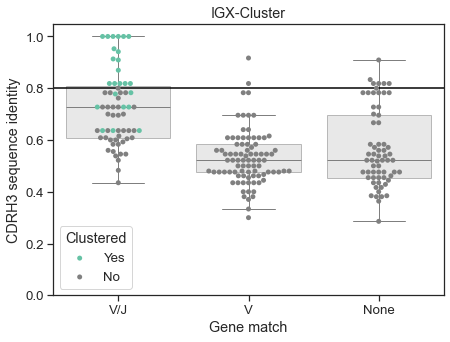

In [27]:
sns.set(style=("ticks"), font_scale=1.2, palette="Set2")
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sns.swarmplot(data=antibody_pairs_cluster_summary, y="Distance_normalized", x="Gene_match", hue="IGX_clustered", 
    order=["V/J", "V", "None"], palette=["grey", pal[0]], ax=ax)

sns.boxplot(data=antibody_pairs_cluster_summary, y="Distance_normalized", x="Gene_match", order=["V/J", "V", "None"], 
    showfliers=False, color="lightgrey", boxprops=dict(alpha=0.5), ax=ax)
ax.set(title="IGX-Cluster", xlabel="Gene match", ylabel="CDRH3 sequence identity", ylim=(0,1.05))
ax.axhline(0.8, color="black")
ax.legend(title="Clustered", loc="lower left", labels=["Yes", "No"])

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Clonotyping_gene_match.png", dpi=300, transparent=True,
    bbox_inches="tight")

### SPACE2

In [28]:
antibody_pairs_cluster_summary["SPACE2_missed"] = np.where((antibody_pairs_cluster_summary["SPACE2_clustered"] == False) & \
    (antibody_pairs_cluster_summary["SPACE2_clustered_length"] == True), "Missed", "Unable")
antibody_pairs_cluster_summary["SPACE2_missed"] = np.where(antibody_pairs_cluster_summary["SPACE2_clustered"] == True, 
    "Found", antibody_pairs_cluster_summary["SPACE2_missed"])
antibody_pairs_cluster_summary["SPACE2_missed"].value_counts()

SPACE2_missed
Unable    193
Found      14
Missed      6
Name: count, dtype: int64

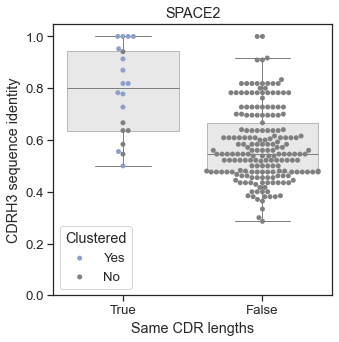

In [29]:
sns.set(style=("ticks"), font_scale=1.2, palette="Set2")
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.swarmplot(data=antibody_pairs_cluster_summary, y="Distance_normalized", x="SPACE2_clustered_length", 
    hue="SPACE2_clustered", order=[True, False], palette=["grey", pal[2]], ax=ax)

sns.boxplot(data=antibody_pairs_cluster_summary, y="Distance_normalized", x="SPACE2_clustered_length", 
    order=[True, False], showfliers=False, color="lightgrey", boxprops=dict(alpha=0.5), ax=ax)

ax.set(title="SPACE2", xlabel="Same CDR lengths", ylabel="CDRH3 sequence identity", ylim=(0,1.05))
ax.legend(title="Clustered", labels=["Yes", "No"])

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/SPACE2_length_match.png", dpi=300, transparent=True,
    bbox_inches="tight")

In [30]:
v_j_gene = pd.DataFrame(cluster_heavy[["V Gene", "J Gene"]].value_counts().values)
v_j_gene["Subset_method"] = "V/J gene"
v_gene = pd.DataFrame(cluster_heavy["V Gene"].value_counts().values)
v_gene["Subset_method"] = "V gene"
cdr_length = pd.DataFrame(space2_full["cluster_by_length"].value_counts().values)
cdr_length["Subset_method"] = "CDR length"
subset_df = pd.concat([v_j_gene, v_gene, cdr_length], axis=0)
subset_df["log"] = np.log(subset_df[0])
subset_df["Subset_method"].value_counts()

Subset_method
CDR length    1891
V/J gene       382
V gene          64
Name: count, dtype: int64

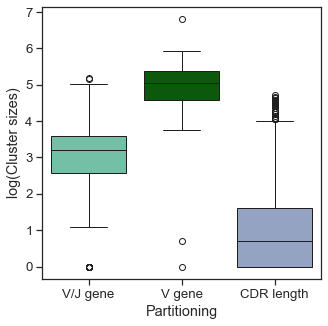

In [31]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.boxplot(data=subset_df, y="log", x="Subset_method", palette=["mediumaquamarine", "darkgreen", pal[2]])
ax.set(xlabel="Partitioning", ylabel="log(Cluster sizes)")

plt.savefig(os.path.dirname(os.getcwd()) + "/figs/Partioning_strategies.png", dpi=300, 
    transparent=True, bbox_inches="tight")